In [128]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
%aimport exv2.experiment_results 

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glasbey



pd.set_option('display.max_columns', None)
sns.set_theme(rc={'figure.figsize':(12, 6)})
sns.set_context("paper")
sns.set_style("whitegrid")

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

palette = glasbey.create_block_palette(
    [4, 3, 3, 2, 2],
    colorblind_safe=True,
    cvd_severity=90
)
sns.set_palette(palette)

dep_focus = ["baseline_vanilla_full","monolith_feature_monolith_full","serverless_feature_serverless_full"]
ms_focus = ["baseline_vanilla_full","obs_feature_object-storage_full","norec_feature_norecommendations_full"]
lable_names = {
    "baseline_vanilla_full": "Microservices",
    'jvm_jvm-impoove_full': "Runtime Improvement",
    'monolith_feature_monolith_full': "Monolith",
    'norec_feature_norecommendations_full' : "Service Reduction",
    'obs_feature_object-storage_full' : "Infrastructure Service Replacement",
    'serverless_feature_serverless_full' : "Serverless",
    'serverless_incl_knative': "Serverless (+KNative)"
}

In [130]:
NEW="data/2024-07-*"
# KARL_LOCAL = "data/data/*"
exr = exv2.experiment_results.ExperimentResults(NEW, load_stats_history=True) # type: ignore
RUN_VARS = exv2.experiment_results.ExperimentResults.RUN_VARS # type: ignore

assert("loadgenerator" not in (list(exr.pods['name'].unique())))
assert("unkown" not in (list(exr.pods['instance'].unique())))


/Users/b/projects/teastore_experiments/exv2/experiment_results.py:182: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_pods = pd.concat(


# Resource Utilization

We try to calculate the ratio of how much resouces (CPU, MEM, ) are consumed vs. how much would have been possible to consume based on the limits set in the k8s deployment.

In [131]:
general_allowance = {
    "teastore-recommender": {"cpu": 2600, "memory": 1332},
    "teastore-webui": {"cpu": 1300, "memory": 1950},
    "teastore-image": {"cpu": 1300, "memory": 1950},
    "teastore-auth": {"cpu": 585, "memory": 1332},
    'teastore-registry':{"cpu": 1000, "memory": 1024}, # not set by default ....
    'teastore-persistence':{"cpu": 1000, "memory": 1024}, # not set by default ....
    'teastore-db':{"cpu": 1000, "memory": 1024}, # not set by default ....
    "teastore-all": {"cpu":1950, "memory":2663},
    "auth": {"cpu": 500, "memory": 500},
}

resouce_scale = {
    "baseline_vanilla_full": {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'jvm_jvm-impoove_full': {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'monolith_feature_monolith_full': {
        'teastore-recommender':0,
        'teastore-webui':0,
        'teastore-image':0,
        'teastore-auth':0,
        'teastore-registry':1,
        'teastore-persistence':0,
        'teastore-db':1,
        "teastore-all":3,
        "auth":0,
    },
    'norec_feature_norecommendations_full' : {
        'teastore-recommender':0,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'obs_feature_object-storage_full' : {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'serverless_feature_serverless_full' : {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':0,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":40, # infinite theorethical, we use the maximum possible on the nodes we use (12+8 cores) -> 40 functions fit
    },
    'serverless_incl_knative' : {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':0,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":40, # infinite theorethical, we use the maximum possible on the nodes we use (12+8 cores) -> 40 functions fit
    },
}



def calculate_maximum_resource_allowance(exp_branch:str):
    scale = resouce_scale[exp_branch]
    max_allowance = {
        "cpu": 0,
        "memory": 0
    }
    for pod_name, pod_scale in scale.items():
        for resource, value in general_allowance[pod_name].items():
            max_allowance[resource] += value * pod_scale
    return max_allowance

[(exp_branch,calculate_maximum_resource_allowance(exp_branch)) for exp_branch in resouce_scale.keys()]

[('baseline_vanilla_full', {'cpu': 20355, 'memory': 22764}),
 ('jvm_jvm-impoove_full', {'cpu': 20355, 'memory': 22764}),
 ('monolith_feature_monolith_full', {'cpu': 7850, 'memory': 10037}),
 ('norec_feature_norecommendations_full', {'cpu': 12555, 'memory': 18768}),
 ('obs_feature_object-storage_full', {'cpu': 20355, 'memory': 22764}),
 ('serverless_feature_serverless_full', {'cpu': 38600, 'memory': 38768}),
 ('serverless_incl_knative', {'cpu': 38600, 'memory': 38768})]

In [137]:
pods = exr.pods.copy()

pods["type"] = pods["name"].apply(lambda x: "-".join(x.split("-")[0:2]))
pod_scale_behavior = pods.groupby(exr.RUN_VARS+["run_time","type"])["type"].count().reset_index(name="count")


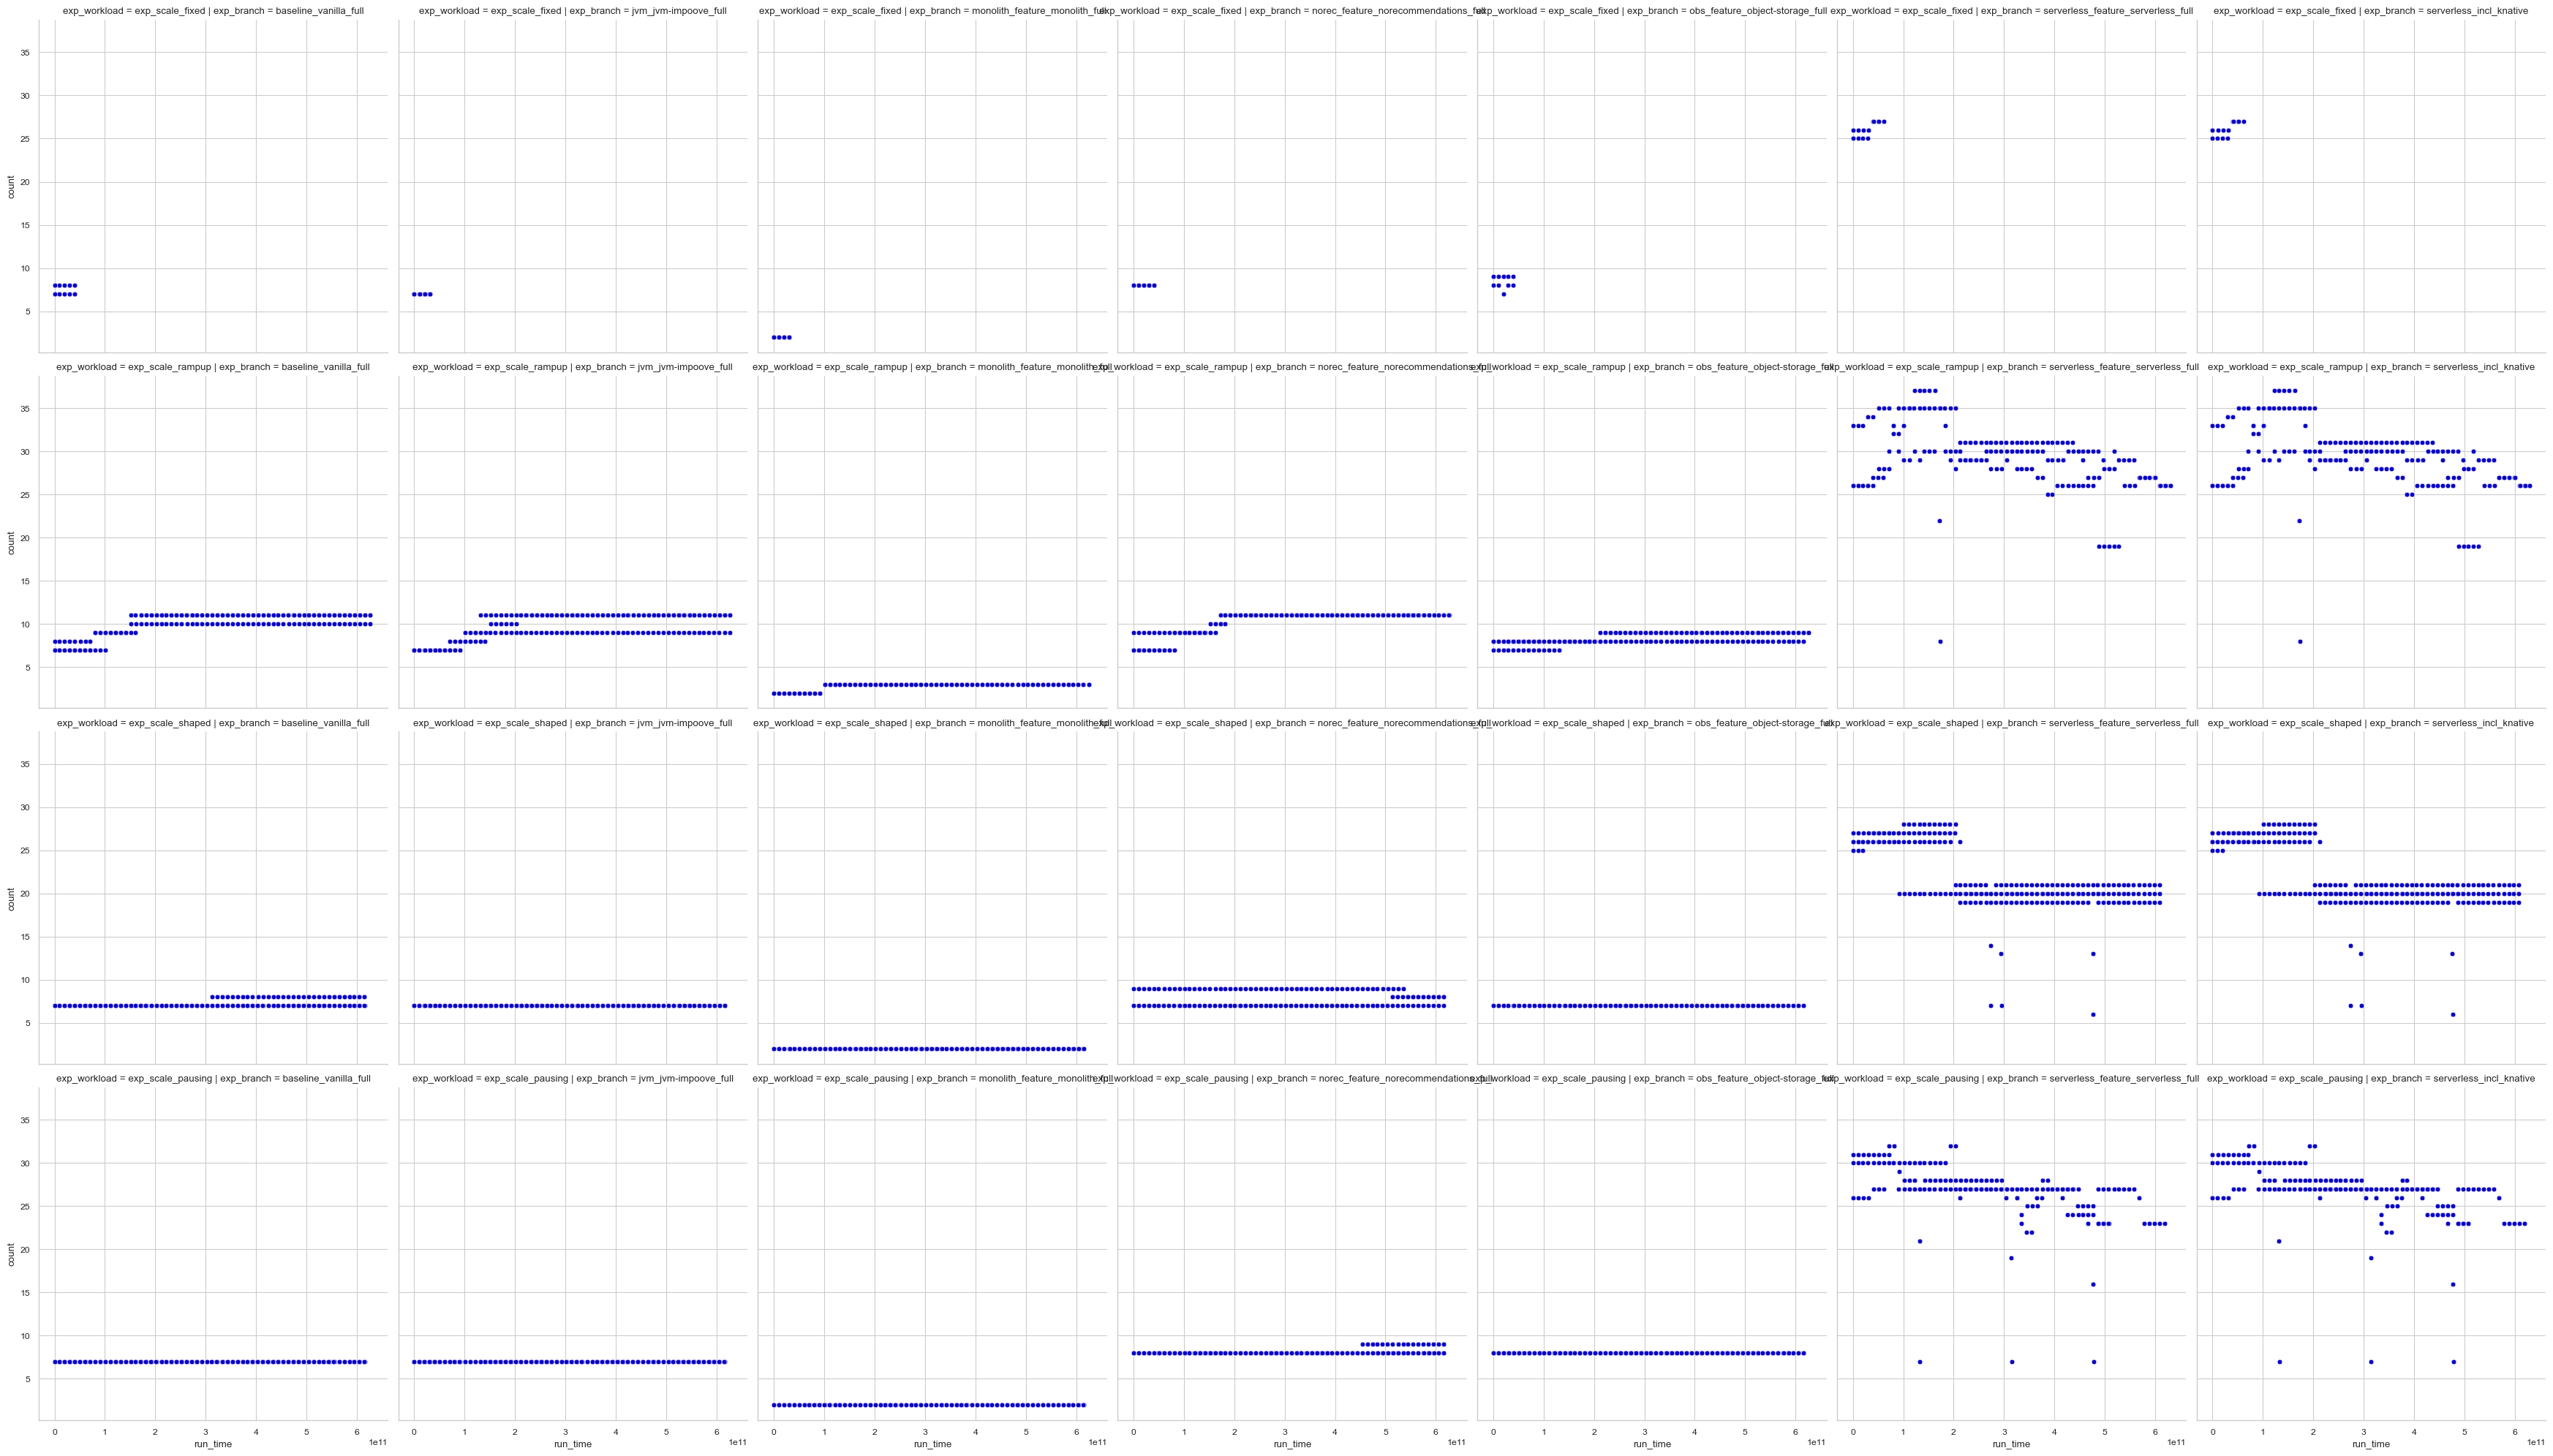

In [ ]:

sns.relplot(
    data=pod_scale_behavior.groupby(exr.RUN_VARS+["run_time"])["count"].sum().reset_index(),
    x="run_time",
    y="count",
    col="exp_branch",
    row="exp_workload"
)

In [138]:
def calulate_resouce_allowence(row):
    if not row["type"] in general_allowance.keys() and not row["type"].startswith("auth") :
        return row
    else:
        
        if row["type"].startswith("auth"):
            cpu = general_allowance["auth"]["cpu"]
            memory = general_allowance["auth"]["memory"]
            max_count = resouce_scale[row["exp_branch"]]["auth"]
        else:
            cpu = general_allowance[row["type"]]["cpu"]
            memory = general_allowance[row["type"]]["memory"]
            max_count = resouce_scale[row["exp_branch"]][row["type"]]
        row["cpu_limit"] = cpu * row["count"]
        row["mem_limit"] = memory * row["count"]
        row["cpu_max"] = cpu * max_count
        row["mem_max"] = memory * max_count
    return row

pod_resouce_utilization = pod_scale_behavior.apply(calulate_resouce_allowence, axis=1)

In [139]:
total_pod_resouce_utilization = pod_resouce_utilization.groupby(exr.RUN_VARS)[["cpu_limit","mem_limit","cpu_max","mem_max"]].sum().reset_index()
total_pod_resouce_utilization["t_cpu_utilization"] = total_pod_resouce_utilization["cpu_limit"] / total_pod_resouce_utilization["cpu_max"]
total_pod_resouce_utilization["t_mem_utilization"] = total_pod_resouce_utilization["mem_limit"] / total_pod_resouce_utilization["mem_max"]
total_pod_resouce_utilization.groupby(["exp_branch","exp_workload"])[["t_cpu_utilization","t_mem_utilization"]].mean()


t_cpu_utilization  \
exp_branch                           exp_workload                           
baseline_vanilla_full                exp_scale_fixed             0.445959   
                                     exp_scale_pausing           0.431589   
                                     exp_scale_rampup            0.574461   
                                     exp_scale_shaped            0.435993   
jvm_jvm-impoove_full                 exp_scale_fixed             0.431589   
                                     exp_scale_pausing           0.431589   
                                     exp_scale_rampup            0.565810   
                                     exp_scale_shaped            0.431589   
monolith_feature_monolith_full       exp_scale_fixed             0.430657   
                                     exp_scale_pausing           0.430657   
                                     exp_scale_rampup            0.670143   
                                     exp_scale_shaped            0.430657   
norec_feature_norecommendations_full exp_scale_fixed             0.803266   
                                     exp_scale_pausing           0.807524   
                                     exp_scale_rampup            0.945982   
                                     exp_scale_shaped            0.750519   
obs_feature_object-storage_full      exp_scale_fixed             0.503439   
                                     exp_scale_pausing           0.495456   
                                     exp_scale_rampup            0.519110   
                                     exp_scale_shaped            0.431589   
serverless_feature_serverless_full   exp_scale_fixed             0.078649   
                                     exp_scale_pausing           0.120728   
                                     exp_scale_rampup            0.142377   
                                     exp_scale_shaped            0.146149   

                                                        t_mem_utilization  
exp_branch                           exp_workload                          
baseline_vanilla_full                exp_scale_fixed             0.452557  
                                     exp_scale_pausing           0.423300  
                                     exp_scale_rampup            0.642817  
                                     exp_scale_shaped            0.432266  
jvm_jvm-impoove_full                 exp_scale_fixed             0.423300  
                                     exp_scale_pausing           0.423300  
                                     exp_scale_rampup            0.624030  
                                     exp_scale_shaped            0.423300  
monolith_feature_monolith_full       exp_scale_fixed             0.409076  
                                     exp_scale_pausing           0.409076  
                                     exp_scale_rampup            0.657639  
                                     exp_scale_shaped            0.409076  
norec_feature_norecommendations_full exp_scale_fixed             0.617327  
                                     exp_scale_pausing           0.623814  
                                     exp_scale_rampup            0.800254  
                                     exp_scale_shaped            0.572863  
obs_feature_object-storage_full      exp_scale_fixed             0.529652  
                                     exp_scale_pausing           0.508962  
                                     exp_scale_rampup            0.540688  
                                     exp_scale_shaped            0.423300  
serverless_feature_serverless_full   exp_scale_fixed             0.079297  
                                     exp_scale_pausing           0.125065  
                                     exp_scale_rampup            0.155937  
                                     exp_scale_shaped            0.151098

In [140]:
real_pod_utilization = pods.groupby(exr.RUN_VARS+["run_time","type"])[["cpu_usage","memory_usage"]].sum()
real_pod_utilization["r_cpu_usage"] = (real_pod_utilization["cpu_usage"]*1000).astype(int)
real_pod_utilization["r_memory_usage"] = real_pod_utilization["memory_usage"].astype(int)
real_pod_utilization.reset_index()
real_total_utilization = pod_resouce_utilization.merge(real_pod_utilization, on=exr.RUN_VARS+["run_time","type"]).groupby(["exp_branch","exp_workload"])[["r_cpu_usage","r_memory_usage","cpu_limit","mem_limit","cpu_max","mem_max"]].sum()
real_total_utilization["r_cpu_utilization"] = 100*real_total_utilization["r_cpu_usage"] / real_total_utilization["cpu_max"]
real_total_utilization["r_mem_utilization"] = 100*real_total_utilization["r_memory_usage"] / real_total_utilization["mem_max"]
real_total_utilization["t_cpu_utilization"] = 100*real_total_utilization["cpu_limit"] / real_total_utilization["cpu_max"]
real_total_utilization["t_mem_utilization"] = 100*real_total_utilization["mem_limit"] / real_total_utilization["mem_max"]
real_total_utilization["cpu_utilization"] = 100*real_total_utilization["r_cpu_usage"] / real_total_utilization["cpu_limit"]
real_total_utilization["mem_utilization"] = 100*real_total_utilization["r_memory_usage"] / real_total_utilization["mem_limit"]
real_total_utilization.reset_index(inplace=True)

real_total_utilization[["exp_branch","exp_workload"]+['r_cpu_utilization','r_mem_utilization','t_cpu_utilization','t_mem_utilization','cpu_utilization','mem_utilization']]

,exp_branch,exp_workload,r_cpu_utilization,r_mem_utilization,t_cpu_utilization,t_mem_utilization,cpu_utilization,mem_utilization
0,baseline_vanilla_full,exp_scale_fixed,0.976664,11.370146,44.595922,45.255667,2.190030,25.124248
1,baseline_vanilla_full,exp_scale_pausing,0.783406,23.875370,43.158929,42.329995,1.815166,56.402960
2,baseline_vanilla_full,exp_scale_rampup,9.556510,41.057611,57.446073,64.281670,16.635618,63.871413
3,baseline_vanilla_full,exp_scale_shaped,1.416510,24.437974,43.599298,43.226572,3.248929,56.534612
4,jvm_jvm-impoove_full,exp_scale_fixed,0.832719,8.764936,43.158929,42.329995,1.929425,20.706206
5,jvm_jvm-impoove_full,exp_scale_pausing,0.859819,10.118221,43.158929,42.329995,1.992215,23.903195
6,jvm_jvm-impoove_full,exp_scale_rampup,13.112751,18.584691,56.581005,62.403042,23.175183,29.781707
7,jvm_jvm-impoove_full,exp_scale_shaped,1.387205,10.457962,43.158929,42.329995,3.214179,24.705796
8,monolith_feature_monolith_full,exp_scale_fixed,2.577859,7.589038,43.065693,40.907578,5.985876,18.551668
9,monolith_feature_monolith_full,exp_scale_pausing,1.791029,11.779491,43.065693,40.907578,4.158830,28.795375


/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_58048/2795015664.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])


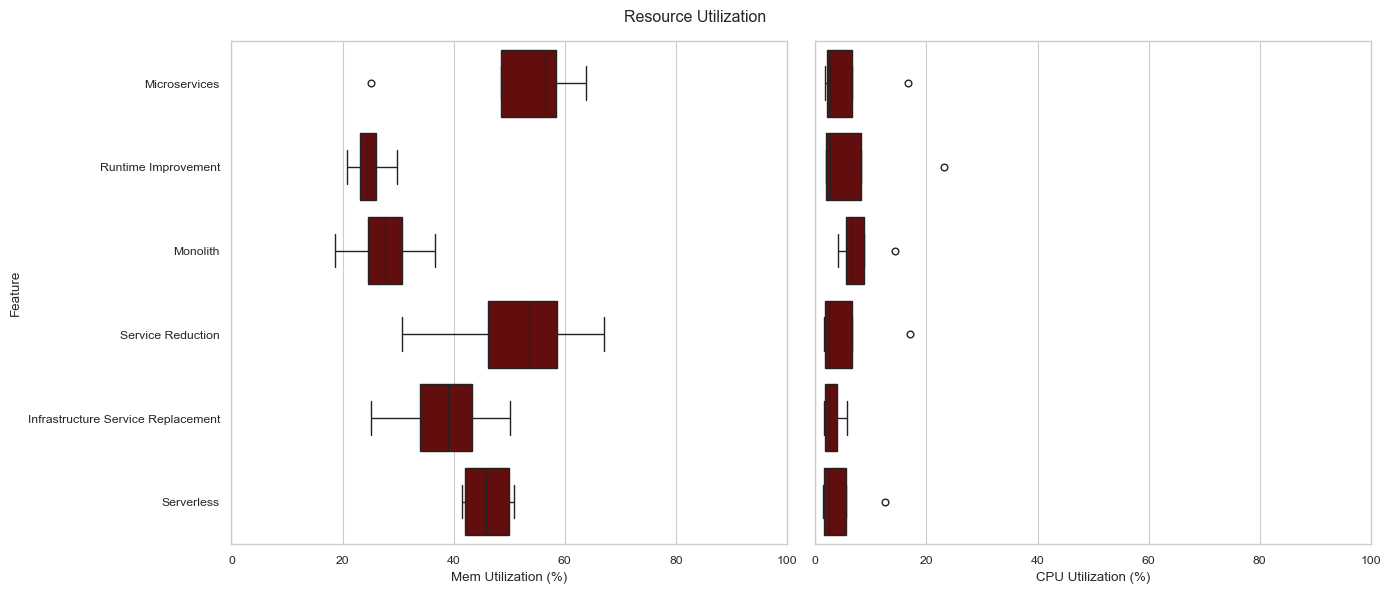

In [141]:
fig, ax = plt.subplots(1,2,figsize=(14, 6))
sns.boxplot(data= real_total_utilization, y="exp_branch", x="mem_utilization",ax=ax[0],color="C4")

ax[0].set_xlabel("Mem Utilization (%)")
ax[0].set_ylabel("Feature")
ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])
ax[0].set_xlim(0,100)

sns.boxplot(data= real_total_utilization, y="exp_branch", x="cpu_utilization",ax=ax[1],color="C4")

ax[1].set_xlabel("CPU Utilization (%)")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].set_xlim(0,100)

fig.set_tight_layout(True)
plt.suptitle("Resource Utilization")
fig.savefig("figs/resouce_utilization.pdf", bbox_inches='tight')

/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_58048/1723339088.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])


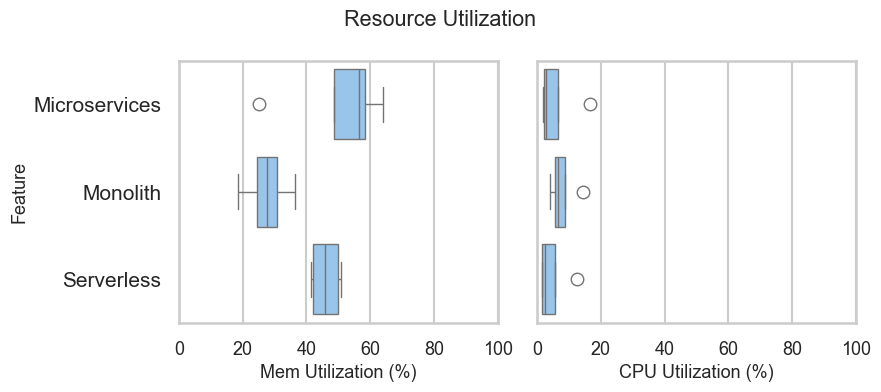

In [143]:
fig, ax = plt.subplots(1,2,figsize=(9, 4))
sns.set_context("talk", rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})
sns.boxplot(data= real_total_utilization[real_total_utilization["exp_branch"].isin(dep_focus)], y="exp_branch", x="mem_utilization",ax=ax[0],color="C3")
ax[0].set_xlabel("Mem Utilization (%)")

ax[0].set_ylabel("Feature")

ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])
ax[0].set_xlim(0,100)
sns.boxplot(data= real_total_utilization[real_total_utilization["exp_branch"].isin(dep_focus)], y="exp_branch", x="cpu_utilization",ax=ax[1],color="C3")

ax[1].set_xlabel("CPU Utilization (%)")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].set_xlim(0,100)
fig.set_tight_layout(True)
plt.suptitle("Resource Utilization")
fig.savefig("figs/resouce_utilization_deployment.pdf", bbox_inches='tight')

/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_58048/1144645920.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])


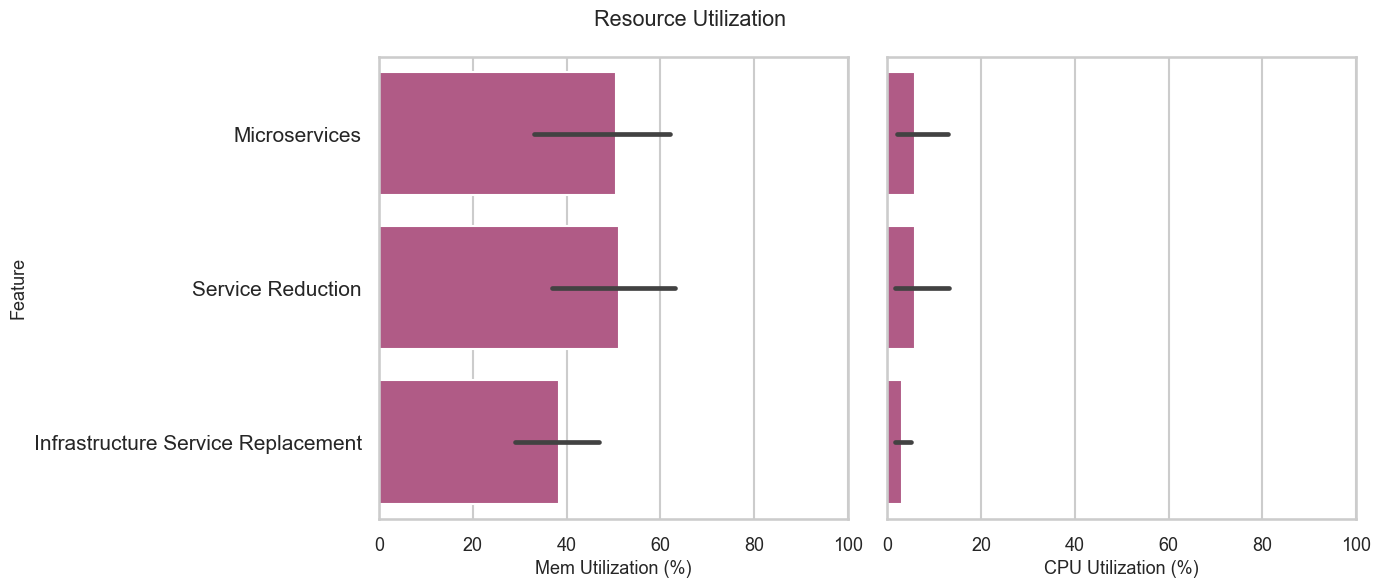

In [144]:
fig, ax = plt.subplots(1,2,figsize=(14, 6))
sns.barplot(data= real_total_utilization[real_total_utilization["exp_branch"].isin(ms_focus)], y="exp_branch", x="mem_utilization",ax=ax[0],color="C9")
ax[0].set_xlabel("Mem Utilization (%)")

ax[0].set_ylabel("Feature")

ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])
ax[0].set_xlim(0,100)
sns.barplot(data= real_total_utilization[real_total_utilization["exp_branch"].isin(ms_focus)], y="exp_branch", x="cpu_utilization",ax=ax[1],color="C9")

ax[1].set_xlabel("CPU Utilization (%)")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].set_xlim(0,100)
fig.set_tight_layout(True)
plt.suptitle("Resource Utilization")
fig.savefig("figs/resouce_utilization_ms_improvment.pdf", bbox_inches='tight')

In [145]:


node_model = {
    "sm-gpu": 32704316//1024,
    "ise-knode6": 32719632//1024,
    "ise-knode1": 32761604//1024,
}
serverless_price = 0.0000166667  # based on aws lambda price per GB-s  (frankfurt)
memory_second_price = 0.00511 / 1024 / 60 # $/MBs based on AWS nfragate memory price per hour (frankfurt) 
vCPU_second_price = 0.04656 / 60 # $/vCPU based on AWS nfragate memory price per hour (frankfurt) 
ws_price = 0.5 / 3_600_000 # based on germany mean kWh price

# serverless_price = 1  # based on aws lambda price per GB-s  (frankfurt)
# memory_second_price = 1 # $/MBs based on AWS nfragate memory price per hour (frankfurt) 
# vCPU_second_price = 1 # $/vCPU based on AWS nfragate memory price per hour (frankfurt) 
# ws_price = 1 # based on germany mean kWh price

import numpy as np
def calculate_cost(row):
    # meory * cpu_seconds * price_per_memory_second + wattage * kwh_price
    return row['memory_usage'] * memory_second_price + np.ceil(row["cpu_usage"]) * vCPU_second_price  + (row["wattage_kepler"] * ws_price)

def calculate_memory_usage(row):
    return row['memory_usage'] * node_model[row['instance']]

# limit to exp_scale_fixed | fixed workload to make it a fair comparison
nodes = exr.nodes[(exr.nodes['instance'].isin(exr.pods['instance'].unique()))].copy()
sl_nodes = nodes[nodes["exp_branch"] == "serverless_feature_serverless_full"].copy()
sl_nodes["exp_branch"] = "serverless_incl_knative"
nodes = pd.concat([nodes,sl_nodes],ignore_index=True)

# XXX we need to caclulate the memory usage for each node as we save the memory usage in percent
nodes["memory_usage"] = nodes.apply(calculate_memory_usage, axis=1)


# We calculate the cpu_seconds memory (MB) and wattage used per second for each node ... 

#"wattage_auxilary","temperture"
nodes = nodes.groupby(exr.RUN_VARS+['run_time','instance'])[["cpu_usage","memory_usage","wattage_kepler","wattage_scaph"]].sum()
nodes['cost'] = nodes.apply(calculate_cost, axis=1)

#pods = exr.pods[exr.pods["exp_workload"] == "exp_scale_fixed"]
pods = exr.pods.copy()
sl_copy = pods[pods["exp_branch"] == "serverless_feature_serverless_full"].copy()
sl_copy["exp_branch"] = "serverless_incl_knative"
pods = pd.concat([pods[pods["namespace"] != "knative-serving"],sl_copy])

pods = pods.groupby(exr.RUN_VARS+['run_time','instance'])[["cpu_usage","memory_usage","wattage_kepler","wattage_scaph"]].sum()

# ... and calculate the runtime overhead by removing the total pod usage from the node usage
# we assume that the worklaod generator run on a separate node outside of the pod nodes
runtime_overhead_data = (nodes - pods)
runtime_overhead_data['cost'] = runtime_overhead_data.apply(calculate_cost, axis=1)
# runtime_overhead_data.groupby(["exp_workload","exp_branch"])[["cost"]].sum()

runtime_overhead_cost = 100*runtime_overhead_data.groupby(["exp_workload","exp_branch"])[["cost"]].sum()/nodes.groupby(["exp_workload","exp_branch"])[["cost"]].sum()
runtime_overhead_cost.reset_index(inplace=True)
runtime_overhead_cost

,exp_workload,exp_branch,cost
0,exp_scale_fixed,baseline_vanilla_full,70.101642
1,exp_scale_fixed,jvm_jvm-impoove_full,27.059767
2,exp_scale_fixed,monolith_feature_monolith_full,48.602226
3,exp_scale_fixed,norec_feature_norecommendations_full,87.895845
4,exp_scale_fixed,obs_feature_object-storage_full,85.214124
5,exp_scale_fixed,serverless_feature_serverless_full,57.774059
6,exp_scale_fixed,serverless_incl_knative,56.560487
7,exp_scale_pausing,baseline_vanilla_full,38.265857
8,exp_scale_pausing,jvm_jvm-impoove_full,42.732243
9,exp_scale_pausing,monolith_feature_monolith_full,46.851927


/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_58048/573203370.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])


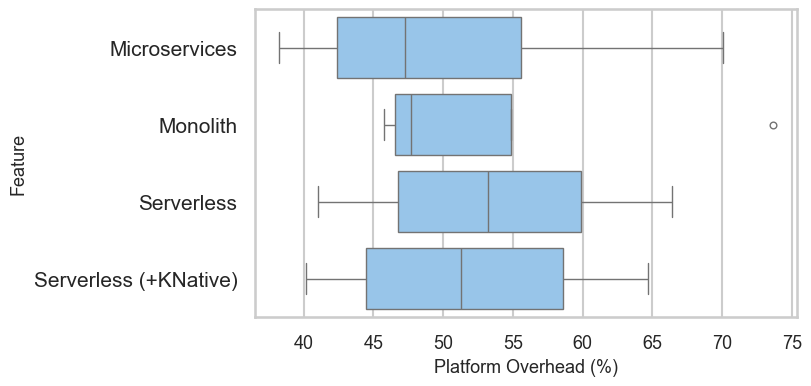

In [146]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.set_context("paper", rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})
sns.boxplot(data= runtime_overhead_cost[runtime_overhead_cost["exp_branch"].isin(dep_focus+["serverless_incl_knative"])], y="exp_branch", x="cost",ax=ax,color="C3")
# ax.set_title("Platform Overhead")
ax.set_ylabel("Feature")
ax.set_xlabel("Platform Overhead (%)")


ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])
fig.savefig("figs/platform_overhead_deploymentes.pdf", bbox_inches='tight')

/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_58048/649773029.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])


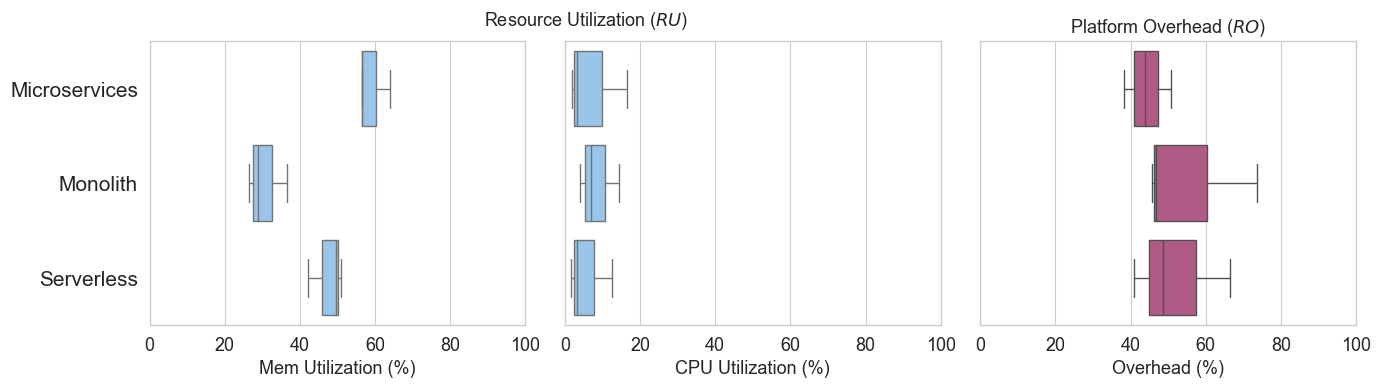

In [152]:
focus = dep_focus
wls = ["exp_scale_rampup","exp_scale_shaped","exp_scale_pausing"]

fig, ax = plt.subplots(1,3,figsize=(14, 4))

sns.set_context(rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})

sns.boxplot(data=real_total_utilization[(real_total_utilization["exp_branch"].isin(focus))&(real_total_utilization["exp_workload"].isin(wls))], y="exp_branch", x="mem_utilization",ax=ax[0],color="C3")
ax[0].set_xlabel("Mem Utilization (%)")

ax[0].set_ylabel("")

ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])
ax[0].set_xlim(0,100)
sns.boxplot(data= real_total_utilization[(real_total_utilization["exp_branch"].isin(focus))&(real_total_utilization["exp_workload"].isin(wls))], y="exp_branch", x="cpu_utilization",ax=ax[1],color="C3")

ax[1].set_xlabel("CPU Utilization (%)")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].set_xlim(0,100)

left_ax = ax[0].get_position()
right_ax = ax[1].get_position()
center_x = (left_ax.x0 + right_ax.x1) / 2 + 0.05
center_y = left_ax.y1 + 0.05  # Slightly above the top of the axes

# Add a custom title between plot 1 and plot 2
title = 'Resource Utilization ($RU$)'
fig.text(center_x, center_y, title, ha='center')

sns.boxplot(data= runtime_overhead_cost[(runtime_overhead_cost["exp_branch"].isin(focus))&(runtime_overhead_cost["exp_workload"].isin(wls))], y="exp_branch", x="cost",color="C9",ax=ax[2])
# ax.set_title("Platform Overhead")
ax[2].set_ylabel("")
ax[2].set_yticklabels([])
ax[2].set_yticks([])
ax[2].set_xlabel("Overhead (%)")
ax[2].set_title("Platform Overhead ($RO$)")
ax[2].set_xlim(0,100)
fig.set_tight_layout(True)
fig.savefig("figs/resouce_and_platfrom_utilization.pdf", bbox_inches='tight')